<a href="https://colab.research.google.com/github/antoniomacu/Regularization-and-Optimization-of-NN-with-Numpy/blob/main/Reg_and_Op_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularization and Optimization Application - Santander Customer Transaction

This notebook is an application example of the functions in `reg_op_functions.py` (implementation of Regularization and Optimization methods for Neural Networks).

In this case I'm going to use the [Santander Customer Transaction Dataset](https://www.kaggle.com/competitions/santander-customer-transaction-prediction/overview) from **Kaggle**.The base Neural Network implemented is the one already programmed in `nn_functions.py` (Deep Neural Network for binary classification). You can find the original repository for that [here](https://github.com/antoniomacu/Deep-Neural-Network-from-scratch).

## 1. Import packages

In order to import `nn_functions.py` and `reg_op_functions.py`, they need to be in a folder uploaded to *Google Drive*, same location as this script.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import the NNet scripts
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Reg and Op Project/')
from nn_functions import *
from reg_op_functions import *

Mounted at /content/drive


This is to upload the data from Kaggle's API - Your own Kaggle's API key need to be uploaded manually in order to access to the online datasets.

In [2]:
# Upload 'kaggle.json' API key
from google.colab import files
files.upload()  # Select kaggle.json

# Set up Kaggle credentials
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download the Santander dataset
!kaggle competitions download -c santander-customer-transaction-prediction

# Unzip files
import zipfile
with zipfile.ZipFile("santander-customer-transaction-prediction.zip","r") as zip_ref:
    zip_ref.extractall("santander")

Saving kaggle.json to kaggle.json
santander-customer-transaction-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


## 2. Dataset Exploration

The **Santander Customer Transaction Dataset** is already splitted in a train and test dataset, each as a .csv file respectively.

For the exploration I'll use the training dataset, as is the most representative one.

In [3]:
data_training = pd.read_csv("santander/train.csv")
data_test = pd.read_csv("santander/test.csv")
data_training.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
print(data_training.shape)

(200000, 202)


In [ ]:
print(data_training.info())
print(data_training.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB
None
              target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317

In [ ]:
columns = data_training.columns

for col in columns:
  n = data_training[col].isnull().sum()
  if n != 0: print(f"Column:{col} has {n} null values")

Now we'll separate the training dataset in **X** and **y**:

In [4]:
X_train = data_training.drop(columns=['ID_code', 'target'])
y_train = data_training['target']

In [ ]:
print(data_training.target.value_counts())
print('Non fraudulent transactions %:', (data_training['target'] == 0).sum()/ len(data_training))
print('Fraudulent transactions %:', (data_training['target'] == 1).sum()/ len(data_training))

max = 0
min = 0
for col in X_train.columns:
  if X_train[col].max() > max: max = X_train[col].max()
  if X_train[col].min() < min: min = X_train[col].min()
print(f"Max value: {max}")
print(f"Min value: {min}")

target
0    179902
1     20098
Name: count, dtype: int64
Non fraudulent transactions %: 0.89951
Fraudulent transactions %: 0.10049
Max value: 74.0321
Min value: -90.2525


So we have in our hands a dataset of 200 features (202 columns in total - index - Target) and 200000 rows, each one represents a transaction done by a customer.

* **Target**:

  It's the nature of the transaction - `0` non-fraudulent (89.9%), `1` fraudulent (10%)

* **var1 - var199**:

  Each feature represents a statistical or transactional property of the customer, but their meaning is hidden to prevent data leakage and preserve privacy. The values are floating numbers ranging from -90.25 to 74.03.

There aren't null or missing values in the dataset.




## 3. Neural Network Training

### 3.1 Preprocessing - Feature Scaling

In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)

# Reshape:
X_train = X_train.T                 # Shape: (features, samples)
y_train = y_train.to_numpy().reshape(1, -1)    # Shape: (1, samples)

### 3.2 Neural Network Training

Now is the time of training the Neural Network! In this case I'll implement the functions of `reg_op_functions.py`. Here is a quick recap of what we can do with them:

* **Initialization of parameters:**
  * **Random**
  * **'He' Initialization** - to improve the performance of layers with ReLU activation.
* **Regularization** - to reduce overfitting:
  * **L2 Regularization**
  * **Dropout Regularization**
* **Optimization** - to reduce computational cost and make training faster:
  * **Mini-batch split**
  * **Momentum Optimization**
  * **Adam Optimization**

The procedure will be: first create a function that brings all this processes together and that allows the user to select which method use. Then train two models with different methods and compare their performance.

Both models will have **mini-batch split** as the dataset is quite big (200k entries).

**A Model)** will have random initialization, L2 regularization and Adam optimization.

**B Model)** will have 'He' initialization, Dropout regularization and Momentum optimization.

In [6]:
def reg_op_model(X, Y, layers_dims, initialization, regularization, optimizer, learning_rate=0.0007, mini_batch_size=64, beta=0.9,
                 beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=5000, print_cost=True, decay=None, decay_rate=1):
    """
    Neural network model which can be run in different modes.

    Arguments:
    X -- input data, of shape (200, number examples)
    Y -- true "label" vector (1 for / 0 for red dot), of shape (1, number of examples)
    initialization -- the initialization to be passed, random or he
    regularization -- the regularization to be passed, l2 or dropout
    optimizer -- the optimizer to be passed, momentum or adam
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters
    """
    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 42
    m = X.shape[1]                   # number of training examples
    learning_rate0 = learning_rate   # the original learning rate

    # Intialize Parameters
    if initialization == 'random':
        scale = 0.1
        parameters = initialize_parameters_random(layers_dims, scale)
    elif initialization == 'he':
        parameters = initialize_parameters_he(layers_dims)

    # Initialize the Optimizer
    if optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    # Initialize the Regularization method
    if regularization == 'l2':
        lambd = 0.7
        # Optimization Loop
        for i in range(num_epochs):
            # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
            seed = seed + 1
            minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
            cost_total = 0

            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch

                # Forward propagation
                AL, caches = forward_prop(minibatch_X, parameters)

                # Compute cost and add to the cost total
                cost_total += compute_cost_with_l2_reg(AL, minibatch_Y, parameters, lambd, layers_dims)

                # Backward propagation
                grads = backward_prop_with_l2_reg(AL, minibatch_Y, caches, lambd, parameters)

                # Update parameters
                if optimizer == "momentum":
                    parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
                elif optimizer == "adam":
                    t = t + 1 # Adam counter
                    parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                                       t, learning_rate, beta1, beta2, epsilon)
            cost_avg = cost_total / m
            if decay:
                learning_rate = decay(learning_rate0, i, decay_rate)

            # Print the cost every 100 epochs
            if print_cost and i % 100 == 0:
              print("Cost after epoch %i: %f" % (i, cost_avg))
            if print_cost and i % 10 == 0:
              costs.append(cost_avg)

    elif regularization == 'dropout':
        keep_prob = 0.86
        # Optimization Loop
        for i in range(num_epochs):
            # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
            seed = seed + 1
            minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
            cost_total = 0

            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch

                # Forward propagation
                AL, caches = forward_propagation_with_dropout(minibatch_X, parameters, keep_prob)

                # Compute cost and add to the cost total
                cost_total += cost_function(AL, minibatch_Y)

                # Backward propagation
                grads = backward_prop_with_dropout(AL, minibatch_Y, caches, keep_prob)

                # Update parameters
                if optimizer == "momentum":
                    parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
                elif optimizer == "adam":
                    t = t + 1 # Adam counter
                    parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                                       t, learning_rate, beta1, beta2, epsilon)
            cost_avg = cost_total / m
            if decay:
                learning_rate = decay(learning_rate0, i, decay_rate)

            # Print the cost every 100 epoch
            if print_cost and i % 100 == 0:
                print("Cost after epoch %i: %f" % (i, cost_avg))
            if print_cost and i % 10 == 0:
                costs.append(cost_avg)

    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters


In [7]:
X_train = np.array(X_train)
y_train = np.array(y_train)

As the dataset is quite large and the purpose of this project is to test the functions created and the implementation, I'm going to reduce the dataset to a sample of 10k inputs, and also make training faster.

In [8]:
layers_dims = [200, 32, 1]
mini_batch_size = 512
num_epochs = 1000
X_small = X_train[:, :10000]
y_small = y_train[:, :10000]

* **Model A training:**

Cost after epoch 0: 0.000938
Cost after epoch 100: 0.000282
Cost after epoch 200: 0.000167
Cost after epoch 300: 0.000124
Cost after epoch 400: 0.000109
Cost after epoch 500: 0.000094
Cost after epoch 600: 0.000087
Cost after epoch 700: 0.000081
Cost after epoch 800: 0.000076
Cost after epoch 900: 0.000071


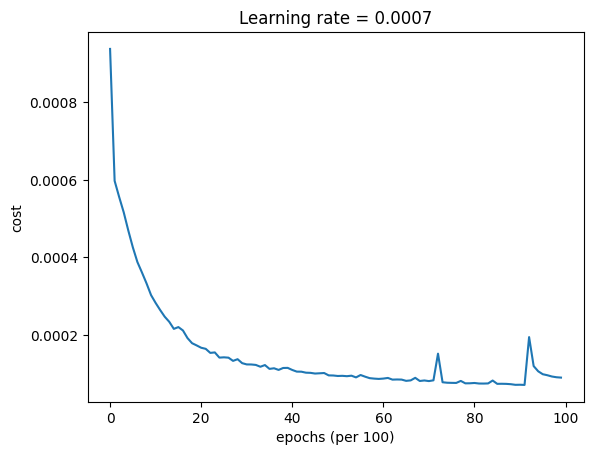

In [10]:
parameters_A = reg_op_model(X_small, y_small, layers_dims, initialization='random', regularization='l2', optimizer='adam', mini_batch_size=mini_batch_size, num_epochs=num_epochs)

* **Model B training:**

Cost after epoch 0: 0.002659
Cost after epoch 100: 0.000668
Cost after epoch 200: 0.000657
Cost after epoch 300: 0.000644
Cost after epoch 400: 0.000634
Cost after epoch 500: 0.000635
Cost after epoch 600: 0.000623
Cost after epoch 700: 0.000626
Cost after epoch 800: 0.000619
Cost after epoch 900: 0.000612


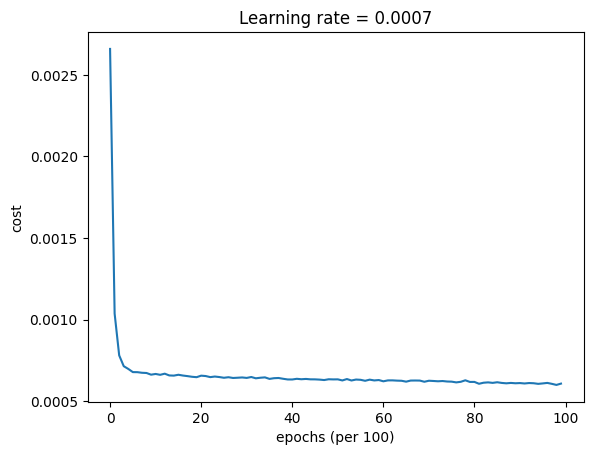

In [11]:
parameters_B = reg_op_model(X_small, y_small, layers_dims, initialization='he', regularization='dropout', optimizer='momentum', mini_batch_size=mini_batch_size, num_epochs=num_epochs)

### 3.3 Testing

Now is the time to test the two different models in the test set to obtain predictions and the accuracy of each model!

In [15]:
print(data_test.head())
print(data_test.shape)

  ID_code    var_0    var_1    var_2   var_3    var_4   var_5   var_6  \
0  test_0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493   
1  test_1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196   
2  test_2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950   
3  test_3   8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397   
4  test_4  11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595   

     var_7   var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.2675  2.1337  ...  -2.1556  11.8495  -1.4300   2.4508  13.7112   2.4669   
1  18.6316 -4.4131  ...  10.6165   8.8349   0.9403  10.1282  15.5765   0.4773   
2  20.2537  1.5233  ...  -0.7484  10.9935   1.9803   2.1800  12.9813   2.1281   
3  20.5660  3.3755  ...   9.5702   9.0766   1.6580   3.5813  15.1874   3.1656   
4  10.6048  2.9890  ...   4.2259   9.1723   1.2835   3.3778  19.5542  -0.2860   

   var_196  var_197  var_198  var_199  
0   4.3654  10.7200  15.4722  -8.7

As this Dataset is prepared for a **Kaggle competition**, there's no Target feature in the test dataset. As I want to measure accuracy and just test the Neural Net implementation, I'm going to generate a **validation dataset** that will be the next 10k entries from the training dataset (the one that we used was from 0 - 10k, so now 10k - 20k)

In [16]:
X_val = X_train[:, 10000:20000]
y_val = y_train[:, 10000:20000]

In [17]:
# Model A
print('Model A test:')
predictions_test, accuracy_test = predict(X_val, y_val, parameters_A)
print(f"Test accuracy: {accuracy_test:.2f}%")
print('----------------------------------------------')
print('Model B test:')
predictions_test, accuracy_test = predict(X_val, y_val, parameters_B)
print(f"Test accuracy: {accuracy_test:.2f}%")

Model A test:
Test accuracy: 86.81%
----------------------------------------------
Model B test:
Test accuracy: 90.20%


And here we have it! The combination selected for **Model B** was more accurate by almost 4%. We could try more combinations, try different hyperparameters... Overall the implementation works smoothly as intended.